<a href="https://colab.research.google.com/github/zyntonyson/Erisk2017/blob/master/02_1_PCA_T_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualización de datos


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
mypath='/content/drive/My Drive/MCE/Participaciones/05.Estancia Jun19/Practicas NLP/Deteccion de depresion/Actualizacion sep 2019'
os.chdir( mypath )

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pandas as pd
import numpy as np

In [0]:

train_df=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
train_df=train_df.replace(np.nan, '', regex=True)
test_df=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
test_df=test_df.replace(np.nan, '', regex=True)

In [0]:
def generate_data(df,nchunks=1):
  data=df['Chunk_1']
  data.rename(columns={'Chunk_1': 'x'})
  if nchunks<=1:
   pass
  else:
    for i in range(2,nchunks):
      chunk='Chunk_'+str(i)
      data+=df[chunk]
  return data.values

In [0]:
#  Representación de embedding
dirW2VGoogle = '/content/drive/My Drive/MCE/Participaciones/05.Estancia Jun19/Practicas NLP/Deteccion de depresion/Embbedings/word2vec Google news/GoogleNews-vectors-negative300.bin.gz'
model_google = KeyedVectors.load_word2vec_format(dirW2VGoogle, binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Se obtiene las representaciones de los vectores de Google
def w2v_google(word,model=model_google):
    if word not in model.vocab:
        return 300*[0]
    else:
        return model[word]


In [0]:
# Dado un número devuelve su reciproco, si es cero se devuelve cero
def mydiag(x):
    if x==0:
        return (0)
    else:
        return (1/x)

In [0]:
# Ajustar BoW y representación de embedding

nChunks=10
# Generar datos
x_train=generate_data(train_df,nChunks)
y_train=train_df['Depress'].values
x_test=generate_data(test_df,nChunks)
y_test=test_df['Depress'].values

# Ajustar BoW
vectorizer_bow = CountVectorizer(max_features=1000)
BoW = vectorizer_bow.fit_transform(x_train)

# Obtener vocabulario 
vocabulary=vectorizer_bow.get_feature_names()

# Contenedor de las representaciones por palabras
# El emmbedding tiene dimension 300, vamos a crear una matriz de embbeding
# Con dimensiones (#nVocab,300)
weigth_google=np.empty((0,300), float)


# Obtener representaciones del vocabulario (matriz de embbedings)
for word in vocabulary:
  weigth_google = np.vstack([weigth_google, w2v_google(word)])

#Auxiliares de entrenamiento: Se obtiene una representación promedio
# de cada documento en función de la cantidad de palabras
# Una combinación lineal con la matriz de embbedings

DocTec=BoW.toarray()    
diag=np.diag(list(map(mydiag,DocTec.sum(axis=1))))

# Datos para entrenamiento
X_train_google=diag@DocTec@weigth_google

# Datos para prueba
Bow_test=vectorizer_bow.transform(x_test)
DocTec_test=Bow_test.toarray()
diag=np.diag(list(map(mydiag,DocTec_test.sum(axis=1))))
X_test_google=diag@DocTec_test@weigth_google
   

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [0]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_google)

In [0]:
PCA_df=pd.DataFrame(train_df['Depress'].values,columns=['Depress'])
PCA_df['pca-one'] = pca_result[:,0]
PCA_df['pca-two'] = pca_result[:,1] 
PCA_df['pca-three'] = pca_result[:,2]

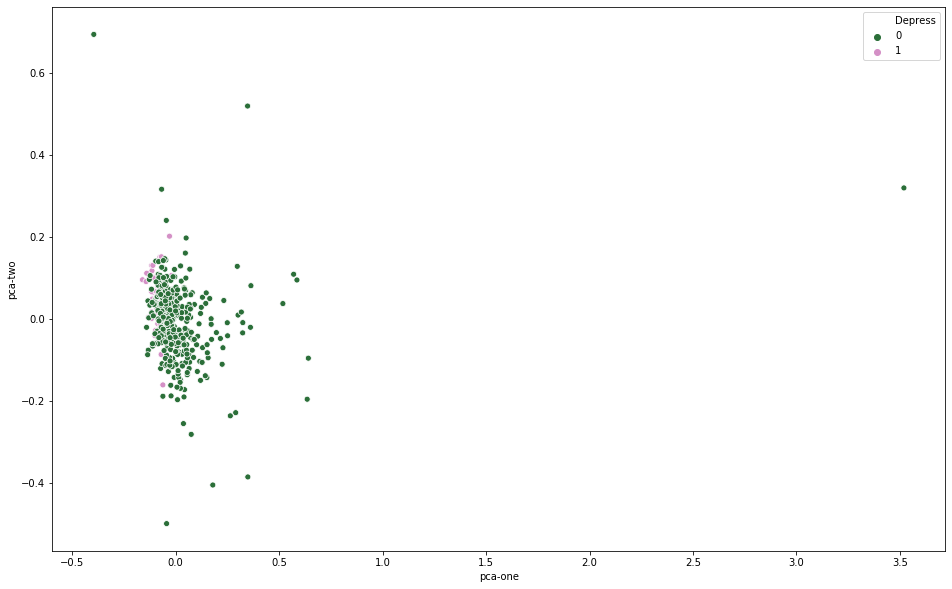

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="Depress",
    palette=sns.color_palette("cubehelix", 2),
    data=PCA_df,
    legend="full",
    alpha=1
)


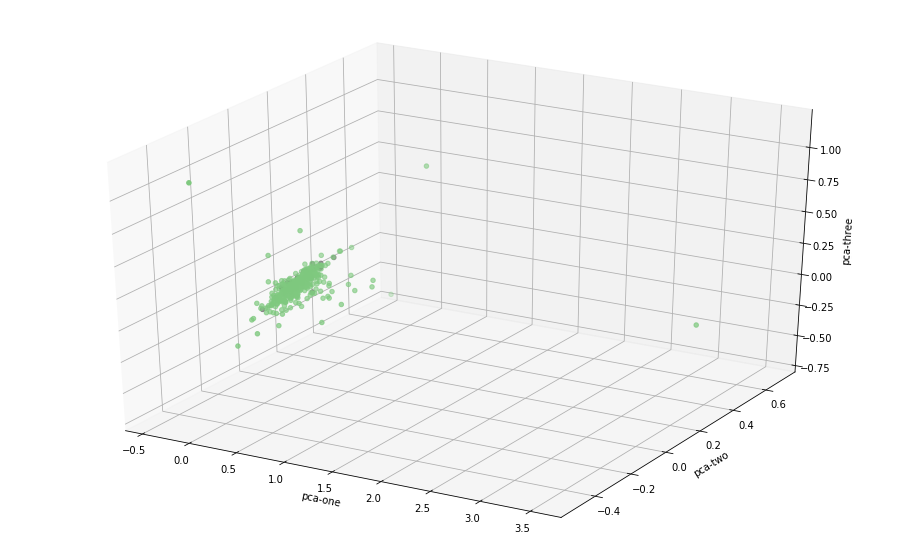

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=PCA_df["pca-one"], 
    ys=PCA_df["pca-two"], 
    zs=PCA_df["pca-three"], 
    c=PCA_df["Depress"], 
    cmap='Accent'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Visualización T-Sne

In [0]:
from __future__ import print_function
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_train_google)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 486 samples in 0.009s...
[t-SNE] Computed neighbors for 486 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 486 / 486
[t-SNE] Mean sigma: 0.065000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.354393
[t-SNE] KL divergence after 1000 iterations: 1.033183
t-SNE done! Time elapsed: 3.1916024684906006 seconds


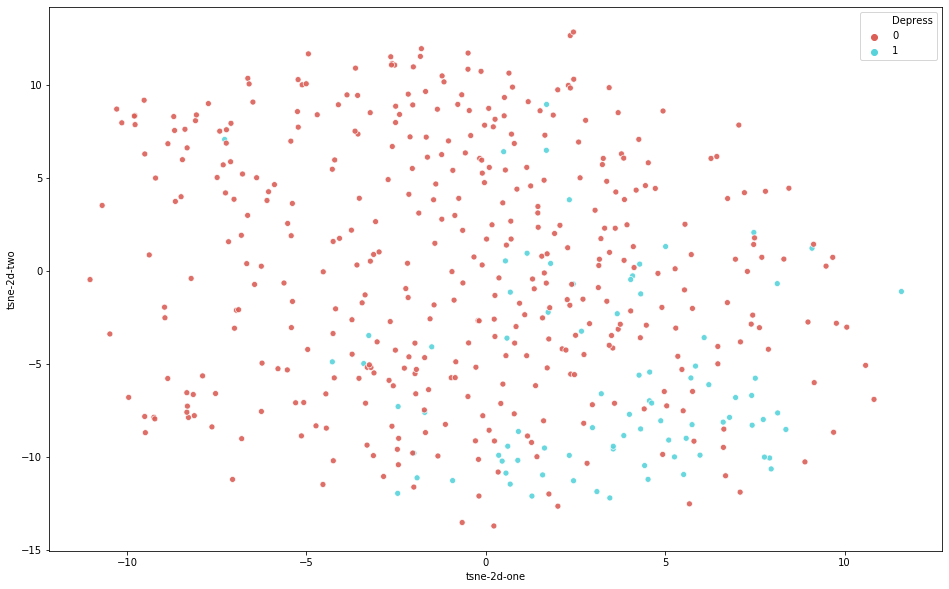

In [0]:
PCA_df['tsne-2d-one'] = tsne_results[:,0]
PCA_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Depress",
    palette=sns.color_palette("hls", 2),
    data=PCA_df,
    legend="full",
    alpha=0.9
)